# TPT pipeline with ERA5

In [1]:
import sys
sys.path.append("../..")

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
import netCDF4 as nc
import feature_template
import feature_stratosphere
from importlib import reload
import sys 
import os
from os import mkdir, makedirs
from os.path import join,exists
from importlib import reload
import pickle
import tpt_utils
from sklearn.cluster import KMeans, MiniBatchKMeans
from datetime import datetime
from calendar import monthrange

In [52]:
import matplotlib
matplotlib.rcParams["font.size"] = 18
%matplotlib inline

# Set up experiment

In [119]:
featurize_flag =                     1

In [3]:
topic_dir = "/scratch/jf4241/ecmwf_data/"
filedict = dict({
    "data": dict({
        "ra": dict({
            "traj": dict({
                "dir": join(topic_dir, "era5_data", "raw_data", "2022-08-14"), # Directory with possibly many files
            }),
            "feat_all": dict({
                "dir": join(topic_dir, "era5_data", "features_all", "2022-08-15"),
                "filename": "era5_features_all.nc",
            }),
            "feat_tpt": dict({
                "dir": join(topic_dir, "era5_data", "features_tpt", "2022-08-15",),
                "filename": "era5_features_tpt.nc",
            }),
        }),
        # TODO: add another directory for S2S hindcasts
    }),
    "results": dict({
        "dir": join(topic_dir, "results", "tpt_quantities", "2022-08-15")
    })
})

In [4]:
# Create the directories if they don't exist already
for src in list(filedict["data"].keys()):
    for data_stage in ["traj","feat_all","feat_tpt"]:
        path = filedict["data"][src][data_stage]["dir"]
        if not exists(path):
            makedirs(path, exist_ok=True)
path = filedict["results"]["dir"]
if not exists(path): makedirs(path, exist_ok=True)

## Read database and compute features. 

In [88]:
month_tags = [f"{year:04}-{month:02}" for year in range(1996,2006) for month in range(1,13)]
ds = xr.open_mfdataset(
    [join(filedict["data"]["ra"]["traj"]["dir"], f"{month_tag}.nc") for month_tag in month_tags]
)

In [122]:
reload(feature_stratosphere)

<module 'feature_stratosphere' from '/home/jf4241/ecmwf/tpt_ecmwf/examples/ssw/feature_stratosphere.py'>

In [123]:
feat_strat = feature_stratosphere.WinterStratosphereFeatures()
feat_strat.set_event_seasonal_params()
feat_strat.set_ab_code()

In [ ]:
if featurize_flag:
    feat_all = dict()
    for src in ["ra"]:
        ds_feature_list = []
        file_list = [f for f in os.listdir(filedict["data"][src]["traj"]["dir"]) if f.endswith(".nc")]
        for filename in file_list:
            ds = xr.open_dataset(join(filedict["data"][src]["traj"]["dir"], filename))
            ds_feature_list += [
                xr.Dataset(
                    data_vars = dict({
                        # WARNING! So that this steps work, the 'feature' coordinate of each observable must be uniquely named. 
                        # For example, if the identity observable and energy observable both have a coordinate called "feature", 
                        # then xarray will assume it's the same and smush them together, filling in NaNs. This restricts what 
                        # we can use as feature names. 
                        "time_feature": feat_strat.time_observable(ds),
                        "ubar_feature": feat_strat.ubar_observable(ds),
                    })
                )
            ]
            ds.close()
        # Combine all the Datasets into a single one, concatenating either by time (if reanalysis) or ensemble (if S2S)
        concat_dim = "time" if src == "ra" else "ensemble"
        feat_all[src] = xr.concat(ds_feature_list,dim=concat_dim) # ensemble is a new dimension
        feat_all[src].to_netcdf(join(filedict["data"][src]["feat_all"]["dir"], filedict["data"][src]["feat_all"]["filename"]))

szn_start_same_year[0] = 2015-10-01T00:00:00.000000
szn_start_same_year[0] = 1998-10-01T00:00:00.000000
szn_start_same_year[0] = 1962-10-01T00:00:00.000000
szn_start_same_year[0] = 2001-10-01T00:00:00.000000
szn_start_same_year[0] = 2012-10-01T00:00:00.000000
szn_start_same_year[0] = 2007-10-01T00:00:00.000000
szn_start_same_year[0] = 1984-10-01T00:00:00.000000
szn_start_same_year[0] = 1960-10-01T00:00:00.000000
szn_start_same_year[0] = 1965-10-01T00:00:00.000000
szn_start_same_year[0] = 1959-10-01T00:00:00.000000
szn_start_same_year[0] = 1962-10-01T00:00:00.000000
szn_start_same_year[0] = 2014-10-01T00:00:00.000000
szn_start_same_year[0] = 1962-10-01T00:00:00.000000
szn_start_same_year[0] = 2010-10-01T00:00:00.000000
szn_start_same_year[0] = 2013-10-01T00:00:00.000000
szn_start_same_year[0] = 1968-10-01T00:00:00.000000
szn_start_same_year[0] = 1995-10-01T00:00:00.000000
szn_start_same_year[0] = 1962-10-01T00:00:00.000000
szn_start_same_year[0] = 1991-10-01T00:00:00.000000
szn_start_sa

In [133]:
!ls -ltrh {join(filedict["data"][src]["feat_all"]["dir"], filedict["data"][src]["feat_all"]["filename"])}

-rw-r--r--. 1 jf4241 root 124K Aug 16 18:07 /scratch/jf4241/ecmwf_data/era5_data/features_all/2022-08-15/era5_features_all.nc


In [111]:
tda = feat_strat.time_observable(ds)

szn_start_same_year[0] = 1996-10-01T00:00:00.000000


In [113]:
ubar = feat_strat.ubar_observable(ds)

In [ ]:
ubar.coords

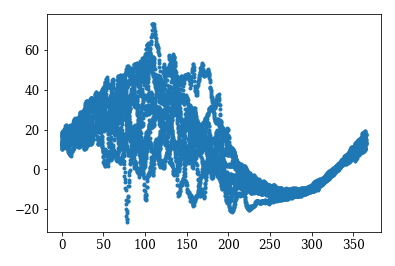

In [117]:
fig,ax = plt.subplots()
ax.scatter(tda.sel(time_type="t_szn"), ubar.sel(ubar_60="ubar_10_60"))

In [108]:
ds['time.day']

<xarray.DataArray 'day' (time: 14612)>
array([ 1,  1,  1, ..., 31, 31, 31])
Coordinates:
  * time     (time) datetime64[ns] 1996-01-01 ... 2005-12-31T18:00:00